In [1]:
%%time
name = 'tmd_training_v3'
import numpy as np
import pandas as pd
import os
import copy
import time

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(22)

import tensorflow as tf
#tf.debugging.set_log_device_placement(True)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import pydot
#import tensorflow_docs as tfdocs

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


2021-10-01 17:10:35.273370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 428306385168190200
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23269408768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13221031031231923607
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6"
]


2021-10-01 17:10:37.532287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-01 17:10:37.549059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-01 17:10:37.642266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-01 17:10:37.642309: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 17:10:37.670364: I tensorflow/stream_executor/platform/default/dso_loader.cc:

CPU times: user 7.7 s, sys: 7.06 s, total: 14.8 s
Wall time: 7.14 s


In [2]:
print('working directory: ',os.getcwd())
Files = [file for file in sorted(os.listdir('../data/test')) if file.endswith('.pkl')]
print('\ntest data files found: \n',Files)
# file = Files[0]
file = 'EIC_test_data_tmdaff.pkl'
test_results = {}


working directory:  /home/share/TMD_Colab/validation/testing

test data files found: 
 ['EIC_test_data_collinearaff.pkl', 'EIC_test_data_currentaff.pkl', 'EIC_test_data_targetaff.pkl', 'EIC_test_data_tmdaff.pkl']


In [3]:
# Define plotting function
def plotPred(trueVal,predVal,title,threshold):
    fig=plt.figure(figsize=(10,10))
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions,alpha=0.05)
    plt.xlabel('True Values [Affinity]',fontsize=20)
    plt.ylabel('Predictions [Affinity]',fontsize=20)
    plt.title(title,fontsize=25)
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims ,color = 'k',linestyle='-')
    # add lines for residual threshold and center
    x1 = np.linspace(0,1-threshold,100)
    plt.plot(x1,x1+threshold, color = 'r',linestyle='--')
    x2 = np.linspace(threshold,1,100)
    plt.plot(x2,x2-threshold, color = 'r',linestyle='--')
    plt.show()
#     from matplotlib.backends.backend_pdf import PdfPages
#     with PdfPages('../figures/tmd_sigmoid.pdf') as pdf:
#         pdf.savefig(fig)
#    plt.savefig('../figures/tmd_sigmoid.png')

def getThresh(residuals):
    badRes = np.ones(len(residuals)).tolist()
    lowThresh = 0.001
    upperThresh = 1.
    threshold = lowThresh
    tolerance = 0.000001
    atol = len(badRes)/len(residuals)
    iterCount = 0

    while np.abs(atol - .05) > tolerance :

        badRes = [res for res in residuals if np.abs(res) > threshold]
        atol = len(badRes)/len(residuals)

        if np.abs(atol - 0.05) < tolerance: 
            break

        else:
            if atol < 0.05:
                upperThresh = threshold
            else:
                lowThresh = threshold

        threshold = (upperThresh + lowThresh)/2 
        iterCount += 1

    print('# residuals: ',len(residuals))
    print('# residuals outside threshold: ',len(badRes))
    print('percent residuals outside threshold: ',len(badRes)/len(residuals))
    print('max badRes: ', max(np.abs(badRes)),', max residual: ',max(np.abs(residuals)))
    print('min BadRes: ', min(np.abs(badRes)))
    print('threshold: ', threshold)
    print('# of iterations: ',iterCount)
    return(threshold)

2021-10-01 17:10:40.352908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-01 17:10:40.355339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-10-01 17:10:40.356805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-01 17:10:40.359205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-10-01 17:10:40.359237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-01 17:10:40.359247: I tensorflow/core/common_ru

# of predictions < 0: 0 
# of predictions > 1: 0
no correction needed
# residuals:  740000
# residuals outside threshold:  37000
percent residuals outside threshold:  0.05
max badRes:  0.2943811521530265 , max residual:  0.2943811521530265
min BadRes:  0.01725743665704116
threshold:  0.01725734412670135
# of iterations:  23
----------------------------

Model Stats
mse:  5.7378903875360265e-05
R-squared:  0.9997237251773562


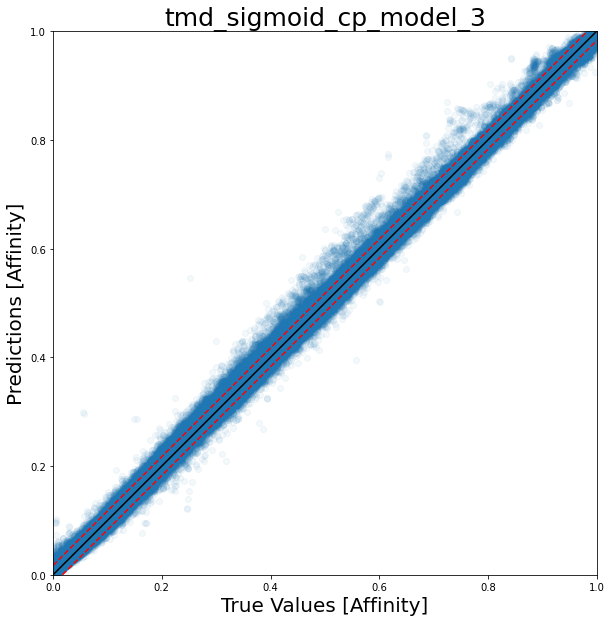

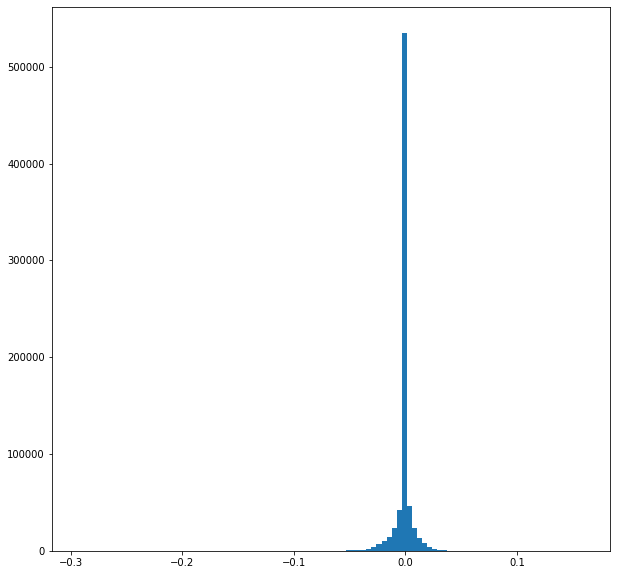

In [4]:
# # test tmd model and create plots for visualization of results
# model_name = 'tmd_DNN_V2_sigmoid_checkpoint_model'

model_name=name+'_cp_model'
model = tf.keras.models.load_model('/home/share/TMD_Colab/validation/training/model/'+model_name)
test_features = np.load('../data/test/'+file,allow_pickle=True)
#test_features = test_features.drop(columns=['currentaff','targetaff', 'collinearaff','hadron'])
#print(test_features.head())
test_labels = test_features.pop('tmdaff')

test_results[model_name] = model.evaluate(test_features, test_labels, verbose=0)
test_predictions = model.predict(test_features).flatten()

negPred=[value for value in test_predictions if value < 0]
giantPred=[value for value in test_predictions if value > 1]
print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

if len(negPred)==0 and len(giantPred)==0:
    print('no correction needed')
else:
    print('setting negative predictions to 0\nsetting predictions > 1 to 1')
    test_predictions[test_predictions<0] = 0
    test_predictions[test_predictions>1] = 1
    print('testing affinity correction...')
    negPred=[value for value in test_predictions if value < 0]
    giantPred=[value for value in test_predictions if value > 1]
    print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))


residuals = test_labels-test_predictions
threshold = getThresh(residuals)
# badRes = [res for res in list(residuals) if np.abs(res) >= threshold] # residuals that are above threshold
# #print(badRes)
# percentBadRes = len(badRes)/len(residuals)

# Calculate R squared
print('----------------------------')
print('\nModel Stats')
R2 = r2_score(test_labels, test_predictions, multioutput='variance_weighted')
print('mse: ',test_results[model_name])
print('R-squared: ',R2)
# print(np.round(percentBadRes,6),'percent of residuals were above threshold 0.2 for',len(test_labels),' predictions')
# print(len(badRes),' residuals were above threshold 0.2 for',len(test_labels),' predictions')
# print('max |residual|: ',max(np.abs(residuals)))

plotPred(test_labels,test_predictions,'tmd_sigmoid_cp_model_3',threshold)
plt.figure(figsize=(10,10))
plt.hist(residuals,bins=100)
plt.show()

In [5]:
%%time
badRes = np.ones(len(residuals)).tolist()
lowThresh = 0.001
upperThresh = 1.
threshold = lowThresh
tolerance = 0.000001
atol = len(badRes)/len(residuals)
iterCount = 0

while np.abs(atol - .05) > tolerance :

    badRes = [res for res in residuals if np.abs(res) > threshold]
    atol = len(badRes)/len(residuals)

    if np.abs(atol - 0.05) < tolerance: 
        break

    else:
        if atol < 0.05:
            upperThresh = threshold
        else:
            lowThresh = threshold

    threshold = (upperThresh + lowThresh)/2 
    iterCount += 1

print('# residuals: ',len(residuals))
print('# residuals outside threshold: ',len(badRes))
print('percent residuals outside threshold: ',len(badRes)/len(residuals))
print('max badRes: ', max(np.abs(badRes)),', max residual: ',max(np.abs(residuals)))
print('min BadRes: ', min(np.abs(badRes)))
print('threshold: ', threshold)
print('# of iterations: ',iterCount)


# residuals:  740000
# residuals outside threshold:  37000
percent residuals outside threshold:  0.05
max badRes:  0.2943811521530265 , max residual:  0.2943811521530265
min BadRes:  0.01725743665704116
threshold:  0.01725734412670135
# of iterations:  23
CPU times: user 14.9 s, sys: 0 ns, total: 14.9 s
Wall time: 14.9 s


In [6]:
accuracy = len([res for res in residuals if np.abs(res) <= threshold])/len(residuals)
print('accuracy: ',accuracy)

accuracy:  0.95


In [7]:
accuracy = len([res for res in residuals if np.abs(res) == 0.0])/len(residuals)
print('accuracy: ',accuracy)

accuracy:  0.1317445945945946


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe8c85fde50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe8c84795b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe8c85fdac0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8c8479cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8c84830a0>],
 'means': []}

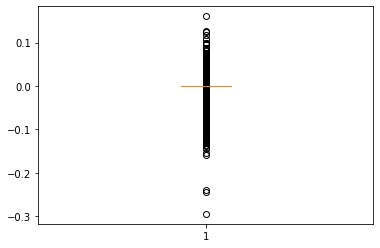

In [8]:
plt.boxplot(residuals)

In [9]:
score = np.sum([1-np.abs(res) for res in residuals])/len(residuals)
print('score: ',score)

score:  0.9968586309899811


In [11]:
np.mean([1-np.abs(res) for res in residuals])

0.9968586309899811

0.9827426558732987